<a href="https://colab.research.google.com/github/MJMortensonWarwick/BAV/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ARIMA Forecasting**
This notebook shows an implementation of SARIMA (Seasonal AutoRegressive Integrated Moving Average) forecasting.

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 9.8 MB 28.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import numpy as np

In [3]:
# add data to a DataFrame
data = {"Date": ["2019/01/01", "2019/04/01", "2019/07/01", "2019/10/01", "2020/01/01", "2020/04/01", "2020/07/01", "2020/10/01", \
                 "2021/01/01", "2021/04/01", "2021/07/01", "2021/10/01", "2022/01/01", "2022/04/01", "2022/07/01", "2022/10/01"], \
        "Sales": [74841.05, 70324.32, 59015.98, 53238.89, 87975.75, 79821.83, 77859.29, 67409.31, 108694.5, 104969.2, 92850.5, \
                  80098.5, 138898.0, 115678.0, 102534.0, 95432.0]}

df = pd.DataFrame(data)
df.tail()

,Date,Sales
11,2021/10/01,80098.5
12,2022/01/01,138898.0
13,2022/04/01,115678.0
14,2022/07/01,102534.0
15,2022/10/01,95432.0


The package requires the date values to be stored as the index, so we make that transformation and plot the time series:

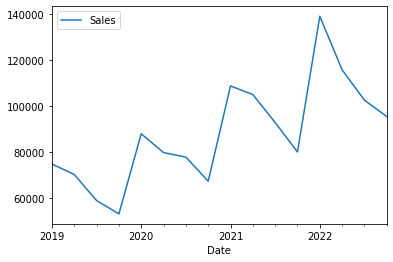

In [4]:
df.set_index("Date", inplace=True) # make Date the index value
df.index = pd.to_datetime(df.index) # convert index to a pandas datetime object

df.plot() # plot time series

The data certainly seems to have an increasing trend in it so likely needs differencing. We can check this with an [Augmented Dickey Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) (ADF) test via Python's *statsmodel*:

In [5]:
from statsmodels.tsa.stattools import adfuller

# perform ADF test - autolag with automatically identify the optimal number of lags
acf_test = adfuller(df["Sales"], autolag="AIC")

# add the ouput to a series with the names of the statistics
output = pd.Series(acf_test[0:4], index=["Test statistic", "p-value", "Lags", "Observations"])

print(output)

Test statistic   -456.054572
p-value             0.000000
Lags                6.000000
Observations        9.000000
dtype: float64


In this instance we can reject the null hypothesis (the data is stationary). We can interpret this as being due to two factors - the visible trand being slight and (probably most importantly) the number of observations being small (p-values and hypothesis tests are impacted by small sample sizes). 

Even though the hypothesis test suggest not to, let's difference the data anyway - partly to show how its done and partly because we think the trend may be there:

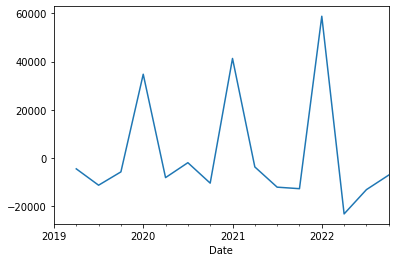

In [6]:
# first order difference
df["diff_1"] = df["Sales"].diff()

# second order difference - won't be used but here for reference
df["diff_2"] = df["diff_1"].diff()

df["diff_1"].plot()

We seem to have now removed the trend! Let's inspect the DataFrame:

In [7]:
df.head()

,Sales,diff_1,diff_2
Date,,,
2019-01-01,74841.05,NaN,NaN
2019-04-01,70324.32,-4516.73,NaN
2019-07-01,59015.98,-11308.34,-6791.61
2019-10-01,53238.89,-5777.09,5531.25
2020-01-01,87975.75,34736.86,40513.95


We notice that the first differenced value is "N/A" so should drop this row before we test the differenced values as before:

In [8]:
df2 = df.dropna(subset=["diff_1"]) # drop rows where we have an NaN in the diff_1 column

# perform ADF test - autolag with automatically identify the optimal number of lags
acf_test = adfuller(df2["diff_1"], autolag="AIC")

# add the ouput to a series with the names of the statistics
output = pd.Series(acf_test[0:4], index=["Test statistic", "p-value", "Lags", "Observations"])

print(output)

Test statistic   -1.678088e+01
p-value           1.264507e-29
Lags              2.000000e+00
Observations      1.200000e+01
dtype: float64


We again reject the null. Also the trend looks linear so we will proceed with the value of 1 for the $d$ parameter (first-order differencing).

Next we need to estimate $D$ parameter - the differencing required for the seasonal component. We can do this in a similar fashion to the previous, but will need to look not at the previous values but those one season before. Pandas' *shift* function allows us to compare to the values one quarter previous, *Note this is not differencing but just calculating the seasonal component to see if it is stationary*: 

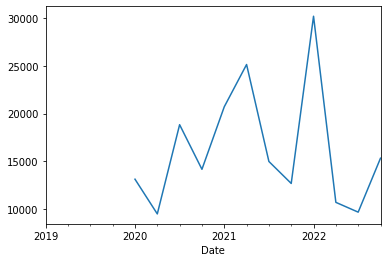

In [9]:
df["diff_seasonal"] = df["Sales"] - df["Sales"].shift(4) # seasonality is quarterly

df["diff_seasonal"].plot()

The seasonal component does seem stationary but again we can try to test this:

In [10]:
df2 = df.dropna(subset=["diff_seasonal"]) # drop rows where we have an NaN in the diff_seasonal column

# perform ADF test - autolag with automatically identify the optimal number of lags
acf_test = adfuller(df2["diff_seasonal"], autolag="AIC")

# add the ouput to a series with the names of the statistics
output = pd.Series(acf_test[0:4], index=["Test statistic", "p-value", "Lags", "Observations"])

print(output)

Test statistic    -3.220329
p-value            0.018838
Lags               1.000000
Observations      10.000000
dtype: float64


In this case we can see that we can reject the null hypothesis and conclude that we do not need to difference the data ($D$=0). However, if need to difference we could do that as follows:

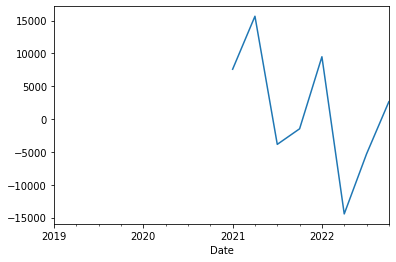

In [11]:
df["diff_seasonal_1"] = df["diff_seasonal"] - df["diff_seasonal"].shift(4) # seasonality is quarterly
df["diff_seasonal_1"].plot()

Lastly we also need the parameters for $p$, $q$, $P$ and $Q$. The previously installed *pmdarima* module will test all the values for us and tell us the best parameters. We'll set maximum values of each parameter as 3 mostly for speed but these are decent maximums given the size of our data and quarterly pattern.

In [12]:
import pmdarima as pm

model = pm.auto_arima(df.Sales, 
                      start_p=1, 
                      start_q=1,
                      max_p=3, max_q=3, # maximum p and q
                      m=4,              # quarterly seasonality
                      d=1,              # first order differencing as above
                      seasonal=True,    # seasonality included
                      start_P=1,
                      start_Q=1,
                      max_P=3, max_Q=3, # maximum P and Q  
                      D=0,              # no seasonal differencing as above 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=347.584, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=342.390, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=343.589, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=345.670, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=348.257, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=343.659, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=343.986, Time=0.26 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=344.617, Time=0.20 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=345.638, Time=0.22 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=341.105, Time=0.08 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=342.352, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=342.444, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=344.226, Time

The experiments identify the following parameters:<br><br>
$p$ = 0<br>
$q$ = 0<br>
$P$ = 2<br>
$Q$ = 1<br><br>
In other words, we only need the last result to predict the **AR** and **MA** component for the general trend, the last three results for the **AR** of the seasonal component, and the last two for the **MA** of the seasonal component.

With these values we can fit the final model:

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df["Sales"], order=(0, 1, 0), seasonal_order=(2, 0, 1, 4))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Lastly we will make predictions for the next four quarters (2023). We start by creating an empty DataFrame:

In [14]:
predictions = ["2023/01/01", "2023/04/01", "2023/07/01", "2023/10/01"]

pred_df = pd.DataFrame(index=predictions, columns=df.columns) # use the new dates for the index and the columns from df
pred_df.index = pd.to_datetime(pred_df.index) # convert index to a pandas datetime object
pred_df.head()

,Sales,diff_1,diff_2,diff_seasonal,diff_seasonal_1
2023-01-01,NaN,NaN,NaN,NaN,NaN
2023-04-01,NaN,NaN,NaN,NaN,NaN
2023-07-01,NaN,NaN,NaN,NaN,NaN
2023-10-01,NaN,NaN,NaN,NaN,NaN


Lastly we will add this DataFrame to the bottom of the previous using Pandas' *concat*. We will create a new column for predictions ("Preds") in which we will put in our predictions for the new dates. Because we only want to predict future dates, there are 16 existing data points, and because Python counts from zero up the first record to predict from is row 15 and the last element will be in row 19 (4x predictions).

In [15]:
df2 = pd.concat([df, pred_df])
df2["Preds"] = result.predict(start=15, end=19)
df2.tail(4)

,Sales,diff_1,diff_2,diff_seasonal,diff_seasonal_1,Preds
2023-01-01,NaN,NaN,NaN,NaN,NaN,136419.574622
2023-04-01,NaN,NaN,NaN,NaN,NaN,129592.898597
2023-07-01,NaN,NaN,NaN,NaN,NaN,121843.470109
2023-10-01,NaN,NaN,NaN,NaN,NaN,113645.170214


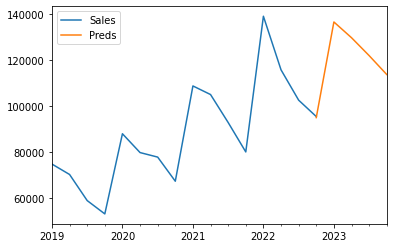

In [16]:
df2[["Sales", "Preds"]].plot()

Overall our results look pretty good! Well done :)